# Fairness Checking: Equalized Odds Constraint Experiment
This notebook uses PuLP to solve the linear program outlined in the "Fairness Checking" document. Here, **we experiment with varying the upper bound constraint on w and see its effects on the objective value.**

In [1]:
!pip install pulp

In [2]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt

In [3]:
# Run this cell to mount your Google Drive.
# from google.colab import drive
# drive.mount('/content/drive')

## Import Predicted Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. The last column, 'prediction,' is our f(X) variable, which can either be 0 or 1.

In [4]:
pred_df = pd.read_csv('./../predicted_data/fair_logreg_adult.csv')

In [5]:
pred_df.head(5)

,Unnamed: 0,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,Age (decade)=>=70,...,Education Years=7,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,Income Binary,predictions
0,21157,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,27813,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,20599,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,17447,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1799,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [6]:
len(pred_df)

7327

In [7]:
# Our protected variable A is race, and a = 0 or a = 1. 
a = pred_df['sex']
np.asarray(a)
a_0_indices = []
a_1_indices = []

for i in range(len(a)):
    if a[i] == 0:
        a_0_indices.append(i)
    elif a[i] == 1:
        a_1_indices.append(i)

In [8]:
# Our true label Y is risk_recid, and y = 0 or y = 1. 
y = pred_df['Income Binary']
np.asarray(y)
y_0_indices = []
y_1_indices = []

for i in range(len(y)):
    if y[i] == 0:
        y_0_indices.append(i)
    elif y[i] == 1:
        y_1_indices.append(i)

In [9]:
# Find the intersection of indices lists to make the pi's
a_0 = set(a_0_indices)
a_1 = set(a_1_indices)
y_0 = set(y_0_indices)
y_1 = set(y_1_indices)

a0_y0 = a_0.intersection(y_0) 
a0_y1 = a_0.intersection(y_1)
a1_y0 = a_1.intersection(y_0)
a1_y1 = a_1.intersection(y_1)

In [10]:
# Sanity check
print(len(y_0))
print(len(a1_y0) + len(a0_y0))
print(len(y_1))
print(len(a0_y1) + len(a1_y1))

5594
5594
1733
1733


In [11]:
# Our pi variables, pi_a_y are simply the proportions where we have A = a, Y = y
pi_0_0 = float(len(a0_y0))/(len(pred_df))
pi_0_1 = float(len(a0_y1))/(len(pred_df))
pi_1_0 = float(len(a1_y0))/(len(pred_df))
pi_1_1 = float(len(a1_y1))/(len(pred_df))

In [12]:
print(pi_0_0)
print(pi_0_1)
print(pi_1_0)
print(pi_1_1)
assert(pi_0_0 + pi_0_1 + pi_1_0 + pi_1_1 == 1.0)

0.3012146854101269
0.0367135253173195
0.4622628633820117
0.19980892589054183


In [13]:
# Our prediction probability is under 'prediction_probs.'
f_X = pred_df['predictions']
np.asarray(f_X)
print(len(f_X))

7327


In [14]:
# Check if the dimensions match
print(len(f_X))
print(len(a0_y1) + len(a0_y0) + len(a1_y1) + len(a1_y0))

7327
7327


## Linear Program Function
Create a reusable function for each linear program.

The argument constraint is the constraint we want to set on the w's. This should be between 0 and 1.

The argument y_value should be Y = 0 or Y = 1, depending on which Y value we want to test EO on. 

In [15]:
# Input: function f(X), constraint, y_value (either 0 or 1)
# Output: (solved) model, weights
def EO_linear_prog(f_X, lower_bound, upper_bound, y_value):
  # Make sure constraint is within bounds
  assert(0 < lower_bound < 1)
  assert(0 < upper_bound < 1)

  if(y_value != 0 and y_value != 1):
    return("Please enter 0 or 1 for the second argument (y_value).")
  
  # Define the linear program as a maximization problem
  model = pulp.LpProblem("Equalized Odds Fairness Checking", pulp.LpMaximize)
  
  # Our w variable in the objective
  # Lower bound constraint set here with lowBound=0 option
  w = pulp.LpVariable.dicts("w", (i for i in range(len(f_X))),lowBound=0, cat='Continuous')
  
  if(y_value == 0):
    # Objective Function
    model += pulp.lpSum(
      [(1./pi_0_0) * w[index] * f_X[index] for index in a0_y0] +
      [- (1./pi_1_0) * w[index] * f_X[index] for index in a1_y0])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 0}) = pi_0_0
    model += pulp.lpSum([w[index] for index in a0_y0]) == pi_0_0
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y0]) == pi_1_0
    
  elif(y_value == 1):
    # Objective Function
    model += pulp.lpSum(
        [(1./pi_0_1) * w[index] * f_X[index] for index in a0_y1] +
        [- (1./pi_1_1) * w[index] * f_X[index] for index in a1_y1])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a0_y1]) == pi_0_1
    
    # Constraint that the \sum(w_i * 1{a = 1, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y1]) == pi_1_1
  
  # Constraint that the w's all sum to 1
  model += pulp.lpSum([w[i] for i in range(len(f_X))]) == 1

  # IMPORTANT: Constraint we set on the w's. Experiment with this
  for weight in w:
    model += w[weight] >= lower_bound
    model += w[weight] <= upper_bound
  
  # Solve the linear program
  model.solve()
  
  return model, w

# Get the results
def weights_dictionary(w):
  results_dict = dict()
  for i in range(len(f_X)):
    results_dict[i] = w[i].varValue
  return results_dict

## Experiment with Linear Program (Y = 0)
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [16]:
epsilon_granule = 0.01

lower_bounds = []
upper_bounds = []
y0_objective_values = []
dist_weights = []
epsilons = []

# Iterate over constraints
for i in range(0, 100):
  epsilon = epsilon_granule * i
  lower_bound = (1 - epsilon)/(len(f_X))
  upper_bound = (1 + epsilon)/(len(f_X))
  model, weights = EO_linear_prog(f_X, lower_bound, upper_bound, 0)
  y0_objective_values.append(pulp.value(model.objective))
  epsilons.append(epsilon)
  lower_bounds.append(lower_bound)
  upper_bounds.append(upper_bound)
  dist_weights.append(weights)

Text(0.5, 1.0, 'Upper Bound Constraint on w vs. EO LP Objective Value (Y = 0)')

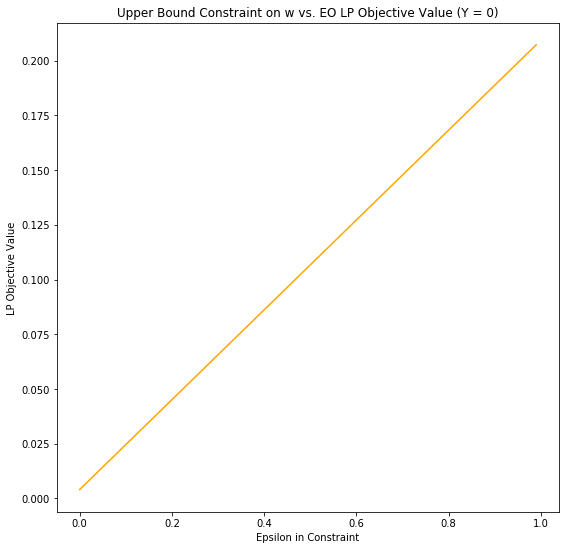

In [17]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, y0_objective_values, 'orange')
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Upper Bound Constraint on w vs. EO LP Objective Value (Y = 0)')

In [18]:
print(len(dist_weights))
print(len(epsilons))

epsilon_to_weights = dict()
for i in range(len(epsilons)):
    epsilon_to_weights[epsilons[i]] = weights_dictionary(dist_weights[i])

100
100


In [19]:
print(len(pred_df))
print(len(epsilon_to_weights[0.01]))

7327
7327


In [20]:
# when weights = 0
print(epsilons[0])
print(y0_objective_values[0])

0.0
0.003987901809669445


## Marginal Distributions (Y = 0)

In [21]:
from collections import defaultdict

# Create a dictionary for our table at the end
table_results = defaultdict(list)

In [22]:
# Find the accuracy of our classifier
tp = len(pred_df[(pred_df['predictions'] == 0) & (pred_df['Income Binary'] == 0)])
tn = len(pred_df[(pred_df['predictions'] == 1) & (pred_df['Income Binary'] == 1)])
acc = float(tp + tn)/len(pred_df)

In [23]:
# Find the lowest epsilon value that has a greater than 10% violation
for i in range(len(epsilons)):
    if(y0_objective_values[i] > 0.1):
        lowest_i = i
        break

print(y0_objective_values[lowest_i])
print(epsilons[lowest_i])
table_results['epsilon'].append(epsilons[lowest_i])
table_results['initial_unfairness'].append(y0_objective_values[0])
table_results['acc'].append(acc)

0.1005005344295715
0.47000000000000003


In [24]:
pred_df['weights'] = epsilon_to_weights[epsilons[lowest_i]].values() # For example, when epsilon = 0.01
pred_df.head(5)

,Unnamed: 0,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,Age (decade)=>=70,...,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,Income Binary,predictions,weights
0,21157,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000201
1,27813,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000201
2,20599,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000201
3,17447,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000201
4,1799,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000072


In [25]:
# Marginal Distribution Function
def marginalize(data, X_attr, weights):
    X_values = data[X_attr]
    key_list = np.unique(X_values)
    X_marginal = {k: 0 for k in key_list}
    for i in range(0, len(X_values)):
        X_marginal[X_values[i]] = X_marginal[X_values[i]] + weights[i]
    return X_marginal

def freq_dict(data, X_attr):
    X_values = data[X_attr].value_counts()
    X_freqs = dict()
    for value in X_values.keys():
        X_freqs[value] = float(X_values[value])/float(len(data))
    return X_freqs

# Returns a tuple of two lists of the items in each dictionary sorted by order of their keys
def graph_tuple(dict1, dict2):
    tuple1 = []
    tuple2 = []
    for key in sorted(dict1.keys()):
        tuple1.append(dict1[key])
        tuple2.append(dict2[key])
    
    return (tuple1, tuple2)

In [26]:
def l1_dist(dict1, dict2):
    l1_total = 0
    for key in sorted(dict1.keys()):
        diff = abs(dict1[key] - dict2[key])
        l1_total = l1_total + diff
        
    return l1_total

In [27]:
# Get the unweighted and weighted distributions on the data
X_sex_freq = freq_dict(pred_df, 'sex')
X_sex_marginal = marginalize(pred_df, 'sex', pred_df['weights'])

print(X_sex_freq)
print(X_sex_marginal)

X_sex_tuple = graph_tuple(X_sex_freq, X_sex_marginal)

{1.0: 0.6620717892725536, 0.0: 0.33792821072744644}
{0.0: 0.3386979608190149, 1.0: 0.6613020226689482}


In [28]:
table_results['sex'].append(l1_dist(X_sex_freq, X_sex_marginal))

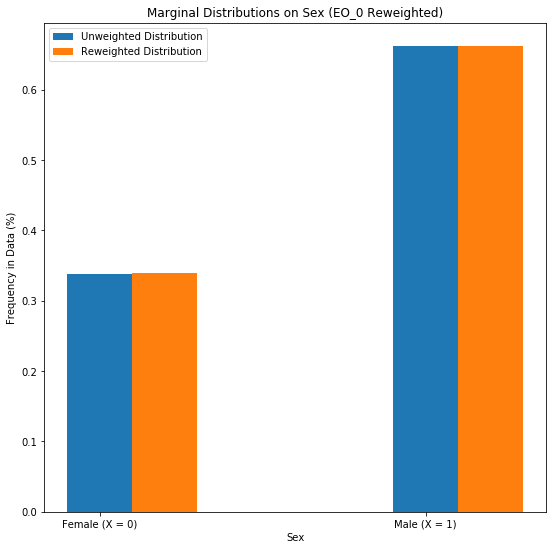

In [29]:
# Marginal Distribution on Sex 

X = np.arange(len(X_sex_freq))
plt.figure(figsize=(9,9))
plt.title('Marginal Distributions on Sex (EO_0 Reweighted)')
plt.bar(X, X_sex_tuple[0], width=0.2, align='center')
plt.bar(X+0.2, X_sex_tuple[1], width=0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Female (X = 0)', 'Male (X = 1)'])
plt.xlabel('Sex')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [30]:
X_race_freq = freq_dict(pred_df, 'race')
X_race_marginal = marginalize(pred_df, 'race', pred_df['weights'])
X_race_tuple = graph_tuple(X_race_freq, X_race_marginal)

In [31]:
table_results['race'] = l1_dist(X_race_freq, X_race_marginal)

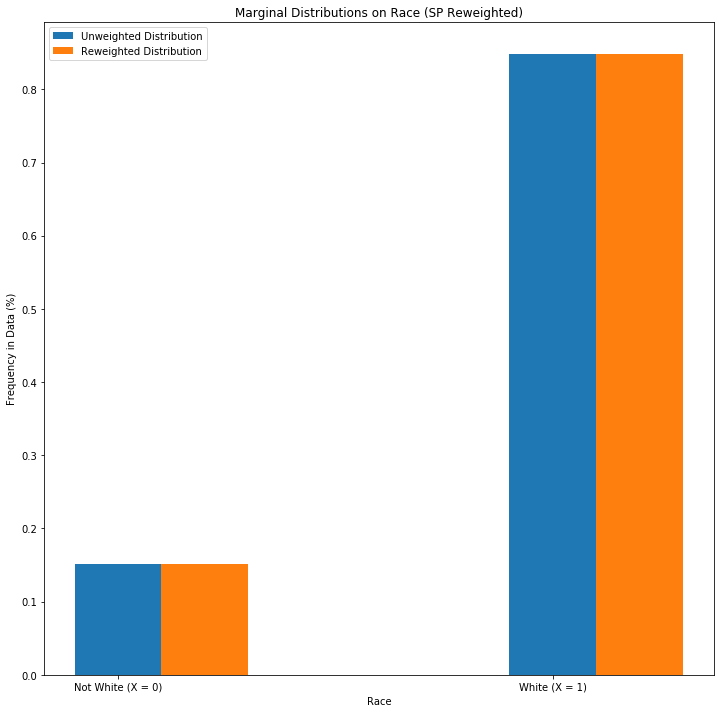

In [32]:
# Marginal Distribution on Age 
X = np.asarray(list(X_race_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Race (SP Reweighted)')
plt.bar(X, X_race_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_race_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not White (X = 0)', 'White (X = 1)'])
plt.xlabel('Race')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [33]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=10')
X_age_marginal = marginalize(pred_df, 'Age (decade)=10', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [34]:
table_results['age_10'] = l1_dist(X_age_freq, X_age_marginal)

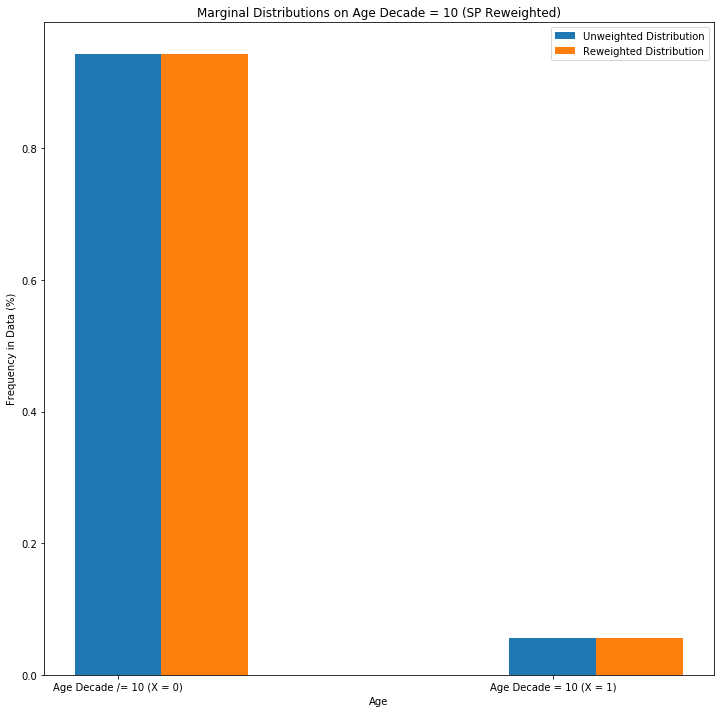

In [35]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 10 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade /= 10 (X = 0)', 'Age Decade = 10 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [36]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=20')
X_age_marginal = marginalize(pred_df, 'Age (decade)=20', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [37]:
table_results['age_20'] = l1_dist(X_age_freq, X_age_marginal)

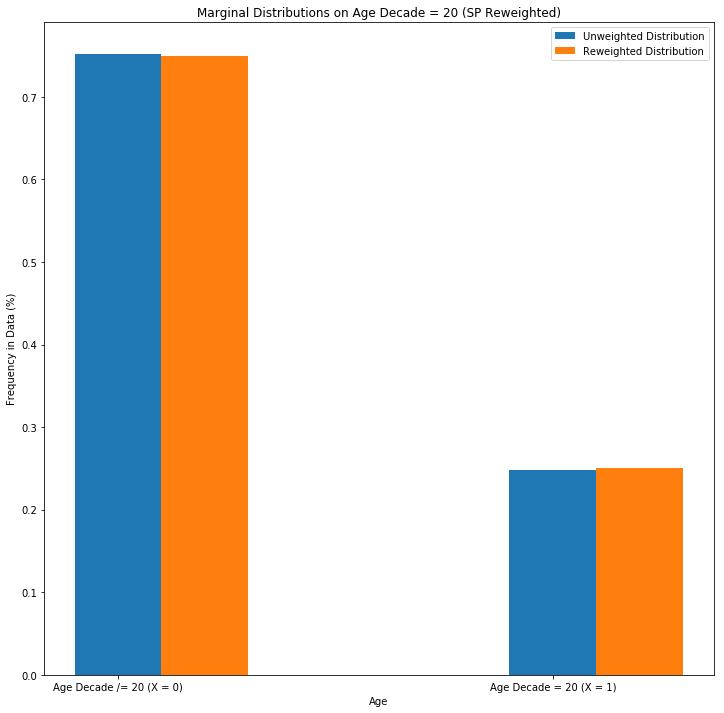

In [38]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 20 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade /= 20 (X = 0)', 'Age Decade = 20 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [39]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=30')
X_age_marginal = marginalize(pred_df, 'Age (decade)=30', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [40]:
table_results['age_30'] = l1_dist(X_age_freq, X_age_marginal)

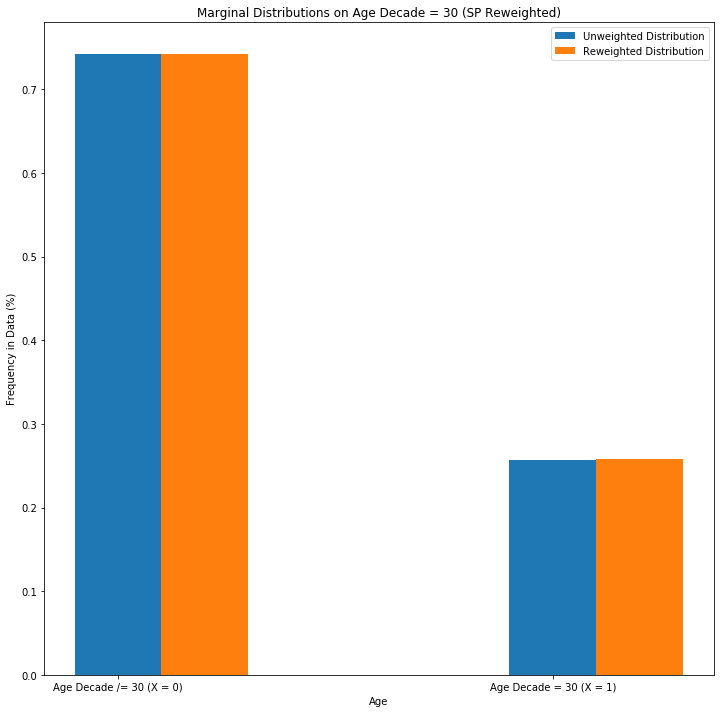

In [41]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 30 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade /= 30 (X = 0)', 'Age Decade = 30 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [42]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=40')
X_age_marginal = marginalize(pred_df, 'Age (decade)=40', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [43]:
table_results['age_40'] = l1_dist(X_age_freq, X_age_marginal)

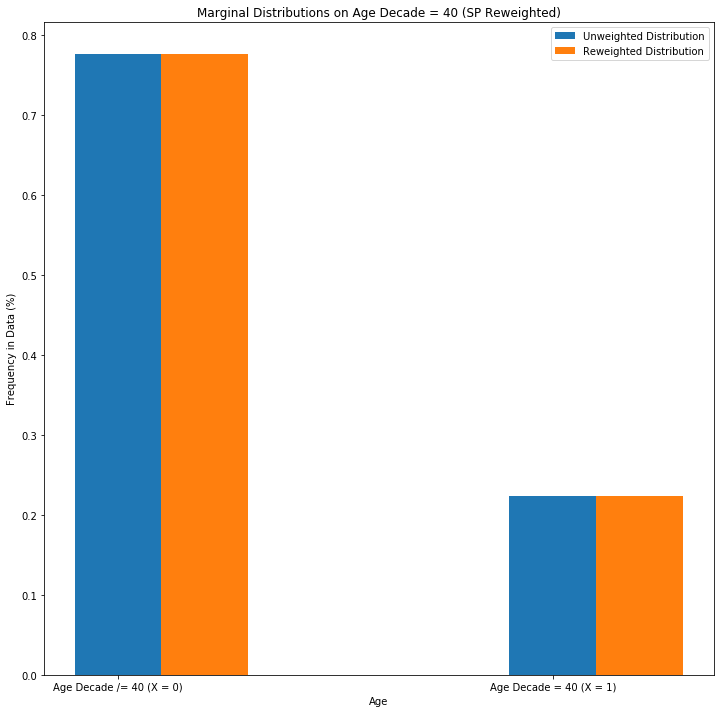

In [44]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 40 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade /= 40 (X = 0)', 'Age Decade = 40 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [45]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=50')
X_age_marginal = marginalize(pred_df, 'Age (decade)=50', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [46]:
table_results['age_50'] = l1_dist(X_age_freq, X_age_marginal)

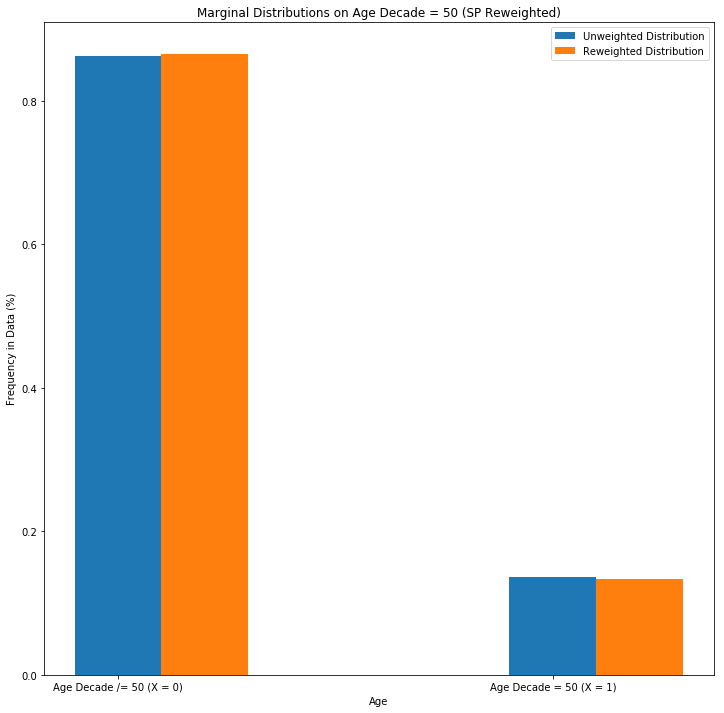

In [47]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 50 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade /= 50 (X = 0)', 'Age Decade = 50 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [48]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=60')
X_age_marginal = marginalize(pred_df, 'Age (decade)=60', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [49]:
table_results['age_60'] = l1_dist(X_age_freq, X_age_marginal)

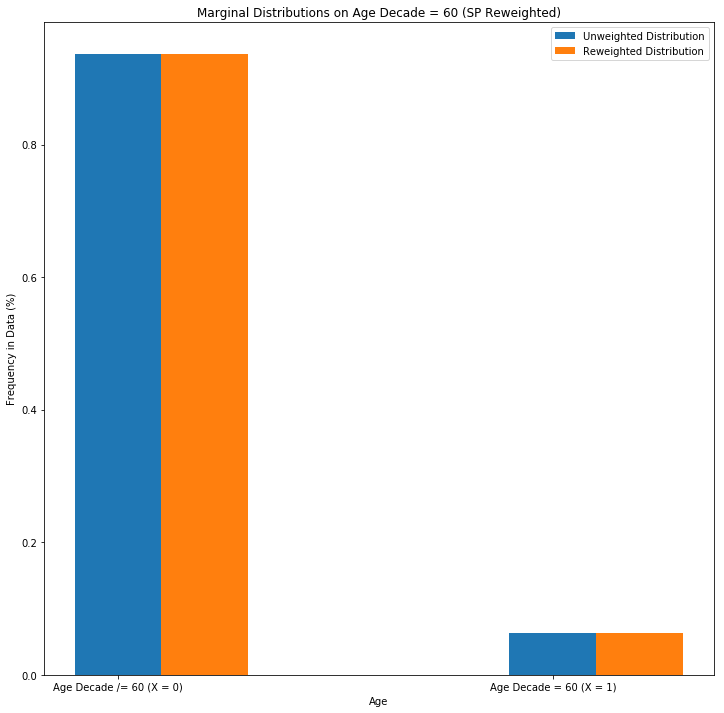

In [50]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 60 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade /= 60 (X = 0)', 'Age Decade = 60 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [51]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=>=70')
X_age_marginal = marginalize(pred_df, 'Age (decade)=>=70', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [52]:
table_results['age_70'] = l1_dist(X_age_freq, X_age_marginal)

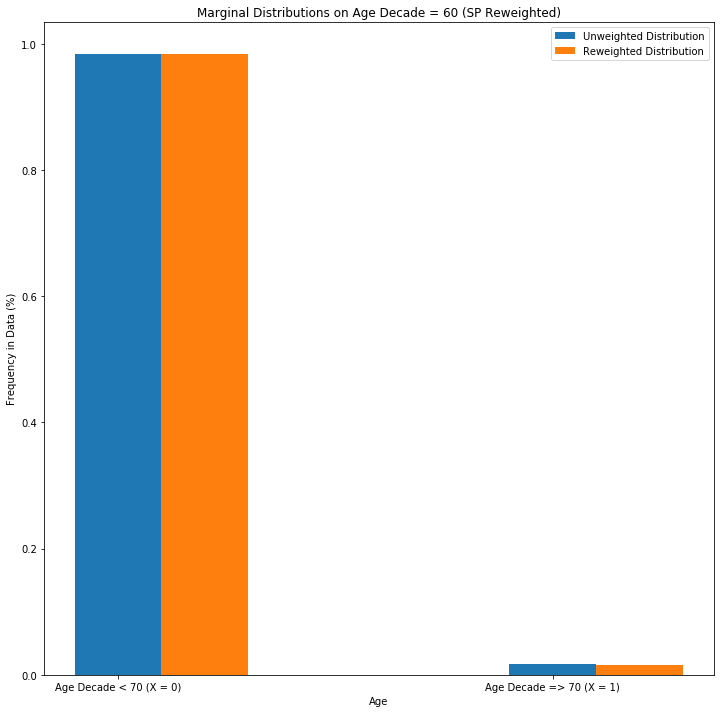

In [53]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 60 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade < 70 (X = 0)', 'Age Decade => 70 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [54]:
# Got tired of doing this manually
X_education_dict = {}
edu_string = 'Education Years=' 

for i in range(6,13):
    feature = edu_string + str(i)
    X_edu_freq = freq_dict(pred_df, feature)
    X_edu_marginal = marginalize(pred_df, feature, pred_df['weights'])
    X_edu_tuple = graph_tuple(X_edu_freq, X_edu_marginal)
    X_education_dict[feature] = [X_edu_marginal.keys(), X_edu_tuple]
    
    table_label = 'edu' + str(i)
    # print(table_label)
    table_results[table_label] = l1_dist(X_edu_freq, X_edu_marginal)

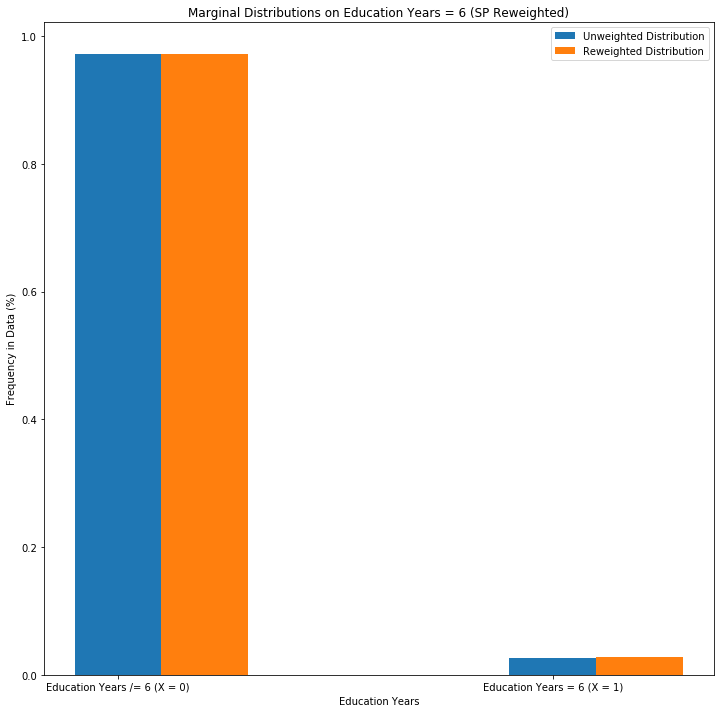

In [55]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=6'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 6 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=6'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=6'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 6 (X = 0)', 'Education Years = 6 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

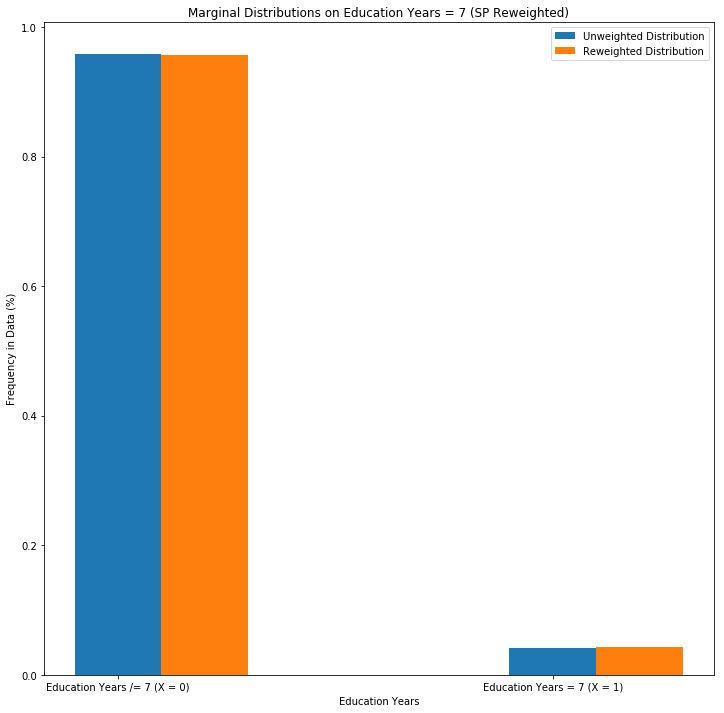

In [56]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=7'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 7 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=7'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=7'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 7 (X = 0)', 'Education Years = 7 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

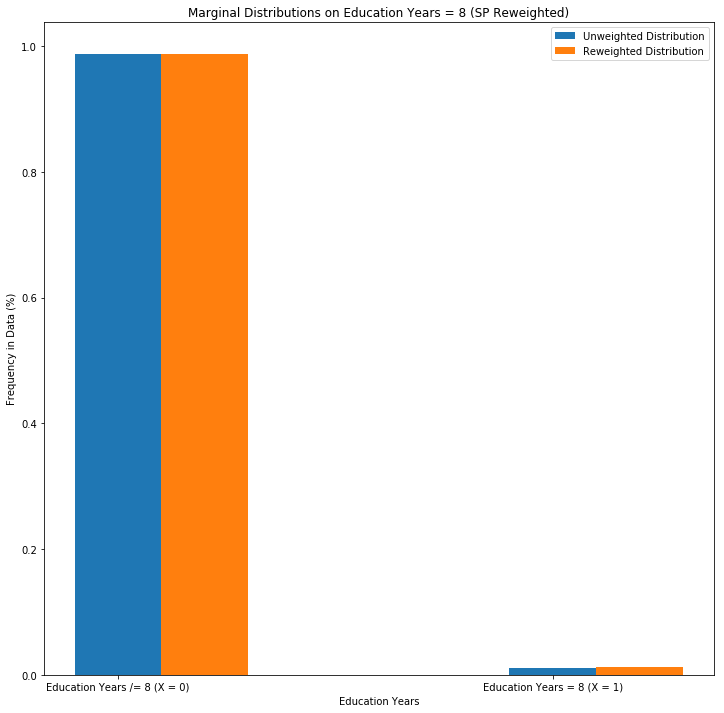

In [57]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=8'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 8 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=8'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=8'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 8 (X = 0)', 'Education Years = 8 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

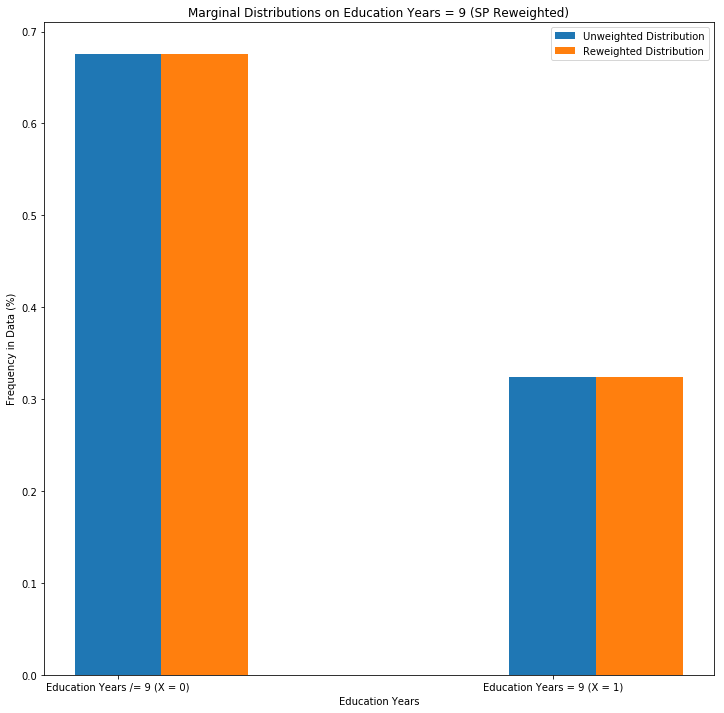

In [58]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=9'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 9 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=9'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=9'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 9 (X = 0)', 'Education Years = 9 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

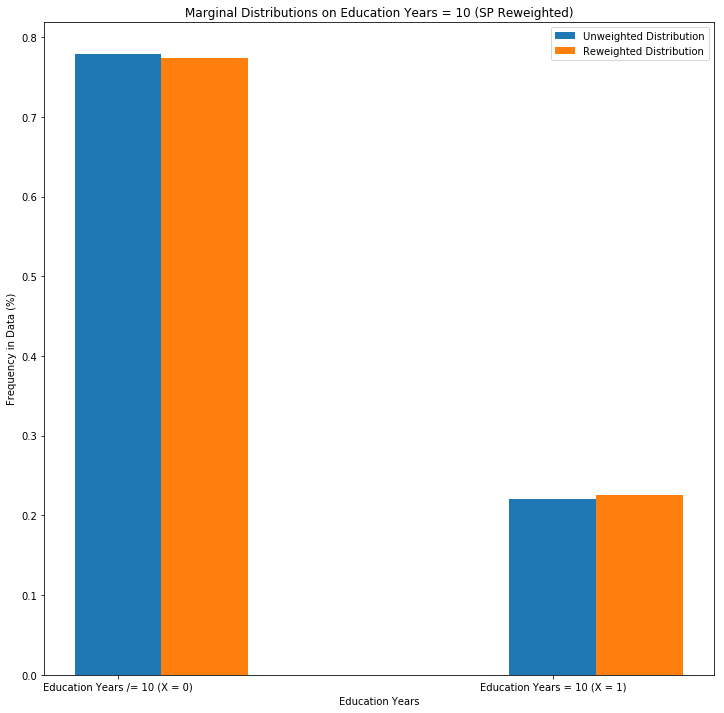

In [59]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=10'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 10 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=10'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=10'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 10 (X = 0)', 'Education Years = 10 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

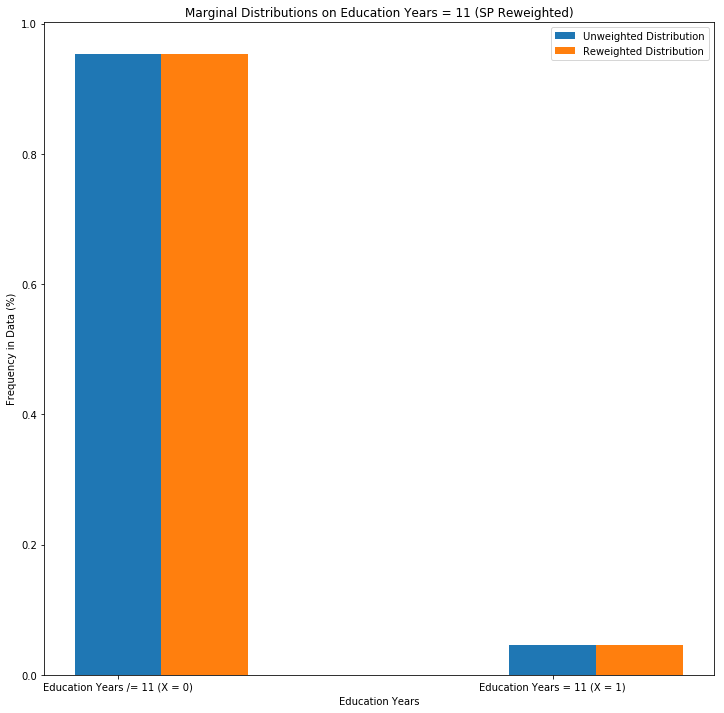

In [60]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=11'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 11 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=11'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=11'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 11 (X = 0)', 'Education Years = 11 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

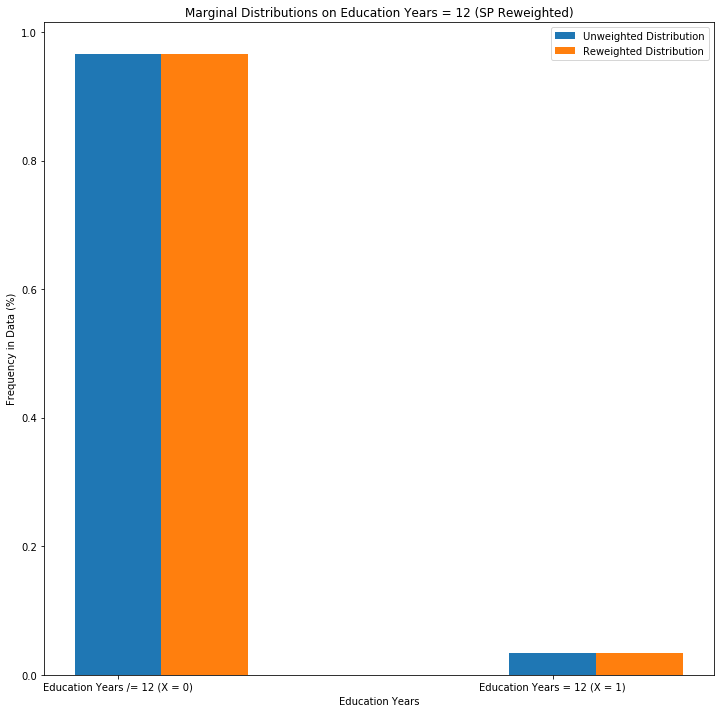

In [61]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=12'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 12 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=12'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=12'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 12 (X = 0)', 'Education Years = 12 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [62]:
X_edu_freq = freq_dict(pred_df, 'Education Years=<6')
X_edu_marginal = marginalize(pred_df, 'Education Years=<6', pred_df['weights'])
X_edu_tuple = graph_tuple(X_edu_freq, X_edu_marginal)

In [63]:
table_results['edu_>6'] = l1_dist(X_edu_freq, X_edu_marginal)

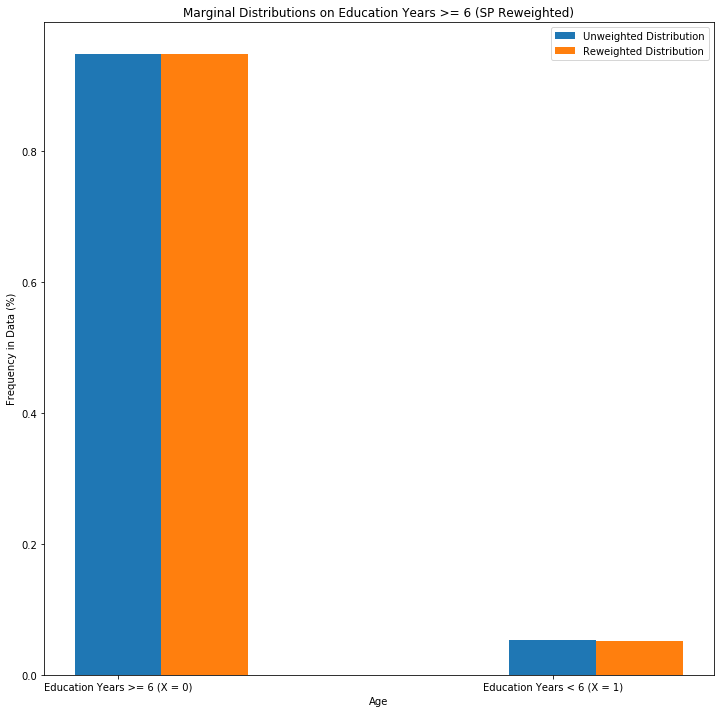

In [64]:
# Marginal Distribution on Age 
X = np.asarray(list(X_edu_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years >= 6 (SP Reweighted)')
plt.bar(X, X_edu_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_edu_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years >= 6 (X = 0)', 'Education Years < 6 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [65]:
X_edu_freq = freq_dict(pred_df, 'Education Years=>12')
X_edu_marginal = marginalize(pred_df, 'Education Years=>12', pred_df['weights'])
X_edu_tuple = graph_tuple(X_edu_freq, X_edu_marginal)

In [66]:
table_results['edu_>12'] = l1_dist(X_edu_freq, X_edu_marginal)

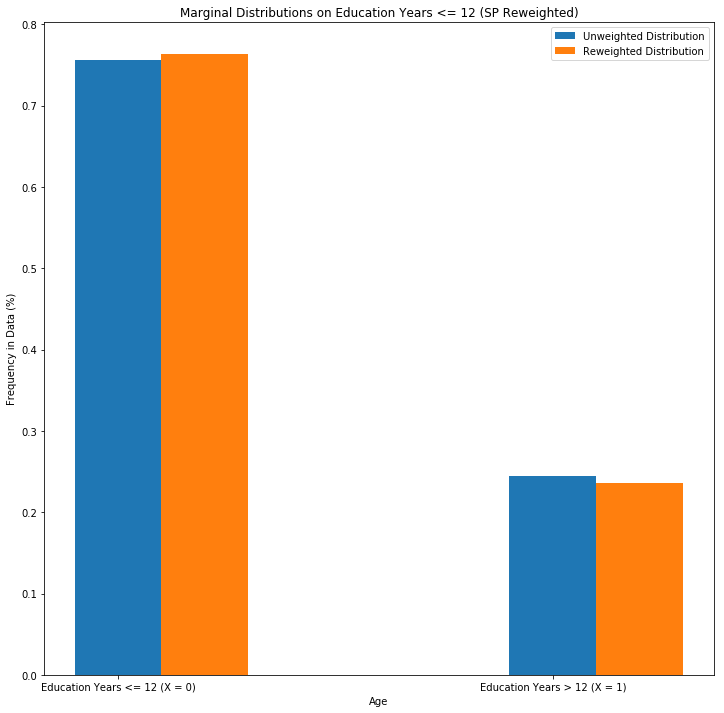

In [67]:
# Marginal Distribution on Age 
X = np.asarray(list(X_edu_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years <= 12 (SP Reweighted)')
plt.bar(X, X_edu_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_edu_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years <= 12 (X = 0)', 'Education Years > 12 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

## Experiment with Linear Program (Y = 1)
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [68]:
epsilon_granule = 0.01

lower_bounds = []
upper_bounds = []
y1_objective_values = []
dist_weights = []
epsilons = []

# Iterate over constraints
for i in range(0, 100):
  epsilon = epsilon_granule * i
  lower_bound = (1 - epsilon)/(len(f_X))
  upper_bound = (1 + epsilon)/(len(f_X))
  model, weights = EO_linear_prog(f_X, lower_bound, upper_bound, 1)
  y1_objective_values.append(pulp.value(model.objective))
  epsilons.append(epsilon)
  lower_bounds.append(lower_bound)
  upper_bounds.append(upper_bound)
  dist_weights.append(weights)

Text(0.5, 1.0, 'Upper Bound Constraint on w vs. EO LP Objective Value (Y = 1)')

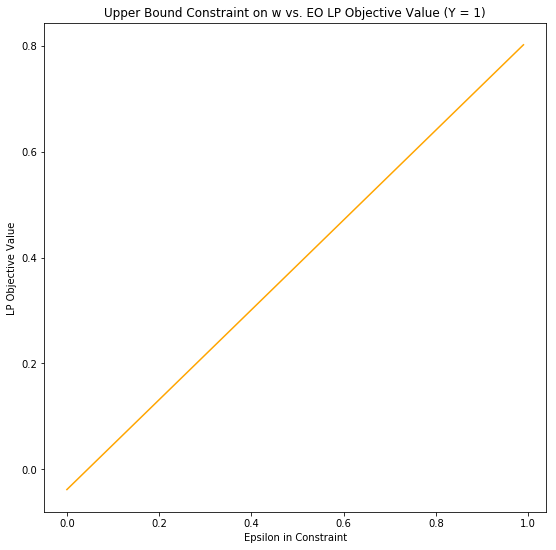

In [69]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, y1_objective_values, 'orange')
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Upper Bound Constraint on w vs. EO LP Objective Value (Y = 1)')

In [70]:
print(len(dist_weights))
print(len(epsilons))

epsilon_to_weights = dict()
for i in range(len(epsilons)):
    epsilon_to_weights[epsilons[i]] = weights_dictionary(dist_weights[i])

100
100


In [71]:
# when weights = 0
print(epsilons[0])
print(y1_objective_values[0])

0.0
-0.03810155086808888


## Marginal Distributions (Y = 1)

In [72]:
# Find the lowest epsilon value that has a greater than 10% violation
for i in range(len(epsilons)):
    if(y1_objective_values[i] > 0.1):
        lowest_i = i
        break

print(y1_objective_values[lowest_i])
print(epsilons[lowest_i])

table_results['epsilon'].append(epsilons[lowest_i])
table_results['initial_unfairness'].append(y1_objective_values[0])
table_results['acc'] = acc

0.10614522360978135
0.17


In [73]:
pred_df['weights'] = epsilon_to_weights[epsilons[lowest_i]].values() # For example, when epsilon = 0.01
pred_df.head(5)

,Unnamed: 0,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,Age (decade)=>=70,...,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,Income Binary,predictions,weights
0,21157,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00016
1,27813,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00016
2,20599,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.00016
3,17447,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00016
4,1799,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00016


In [74]:
# Marginal Distribution Function
def marginalize(data, X_attr, weights):
    X_values = data[X_attr]
    key_list = np.unique(X_values)
    X_marginal = {k: 0 for k in key_list}
    for i in range(0, len(X_values)):
        X_marginal[X_values[i]] = X_marginal[X_values[i]] + weights[i]
    return X_marginal

def freq_dict(data, X_attr):
    X_values = data[X_attr].value_counts()
    X_freqs = dict()
    for value in X_values.keys():
        X_freqs[value] = float(X_values[value])/float(len(data))
    return X_freqs

# Returns a tuple of two lists of the items in each dictionary sorted by order of their keys
def graph_tuple(dict1, dict2):
    tuple1 = []
    tuple2 = []
    for key in sorted(dict1.keys()):
        tuple1.append(dict1[key])
        tuple2.append(dict2[key])
    
    return (tuple1, tuple2)

In [75]:
# Get the unweighted and weighted distributions on the data
X_sex_freq = freq_dict(pred_df, 'sex')
X_sex_marginal = marginalize(pred_df, 'sex', pred_df['weights'])

print(X_sex_freq)
print(X_sex_marginal)

X_sex_tuple = graph_tuple(X_sex_freq, X_sex_marginal)

{1.0: 0.6620717892725536, 0.0: 0.33792821072744644}
{0.0: 0.33832263792000883, 1.0: 0.6616773492199733}


In [76]:
table_results['sex'].append(l1_dist(X_sex_freq, X_sex_marginal))

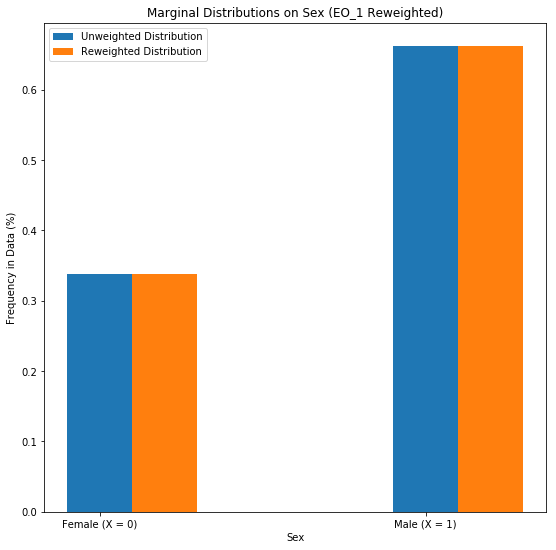

In [77]:
# Marginal Distribution on Sex 

X = np.arange(len(X_sex_freq))
plt.figure(figsize=(9,9))
plt.title('Marginal Distributions on Sex (EO_1 Reweighted)')
plt.bar(X, X_sex_tuple[0], width=0.2, align='center')
plt.bar(X+0.2, X_sex_tuple[1], width=0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Female (X = 0)', 'Male (X = 1)'])
plt.xlabel('Sex')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [78]:
X_race_freq = freq_dict(pred_df, 'race')
X_race_marginal = marginalize(pred_df, 'race', pred_df['weights'])
X_race_tuple = graph_tuple(X_race_freq, X_race_marginal)

In [79]:
table_results['race'] = l1_dist(X_race_freq, X_race_marginal)

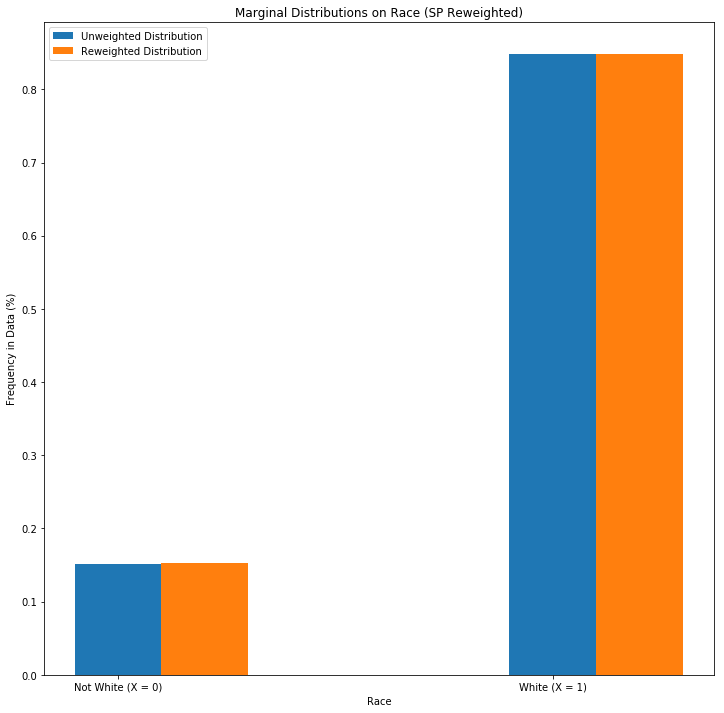

In [80]:
# Marginal Distribution on Race 
X = np.asarray(list(X_race_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Race (SP Reweighted)')
plt.bar(X, X_race_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_race_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not White (X = 0)', 'White (X = 1)'])
plt.xlabel('Race')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [81]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=10')
X_age_marginal = marginalize(pred_df, 'Age (decade)=10', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [82]:
table_results['age_10'] = l1_dist(X_age_freq, X_age_marginal)

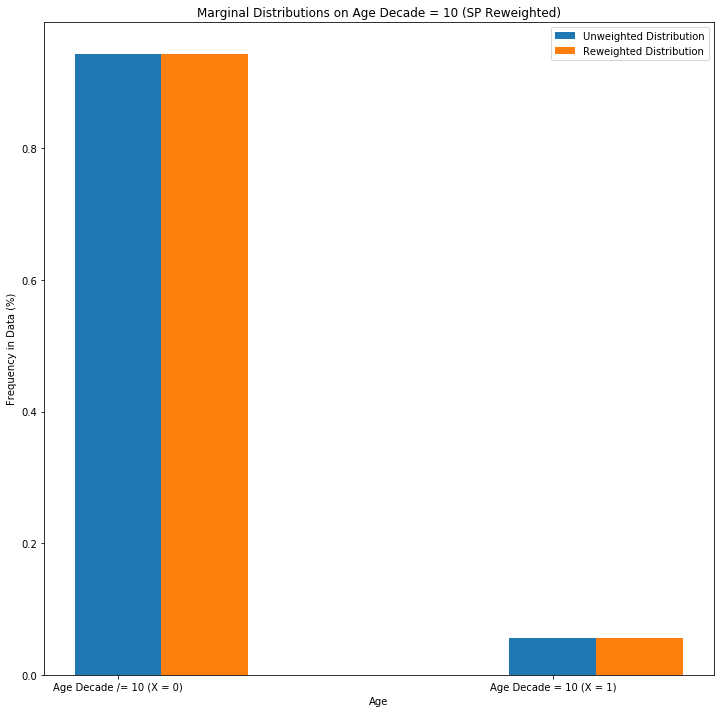

In [83]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 10 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade /= 10 (X = 0)', 'Age Decade = 10 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [84]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=20')
X_age_marginal = marginalize(pred_df, 'Age (decade)=20', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [85]:
table_results['age_20'] = l1_dist(X_age_freq, X_age_marginal)

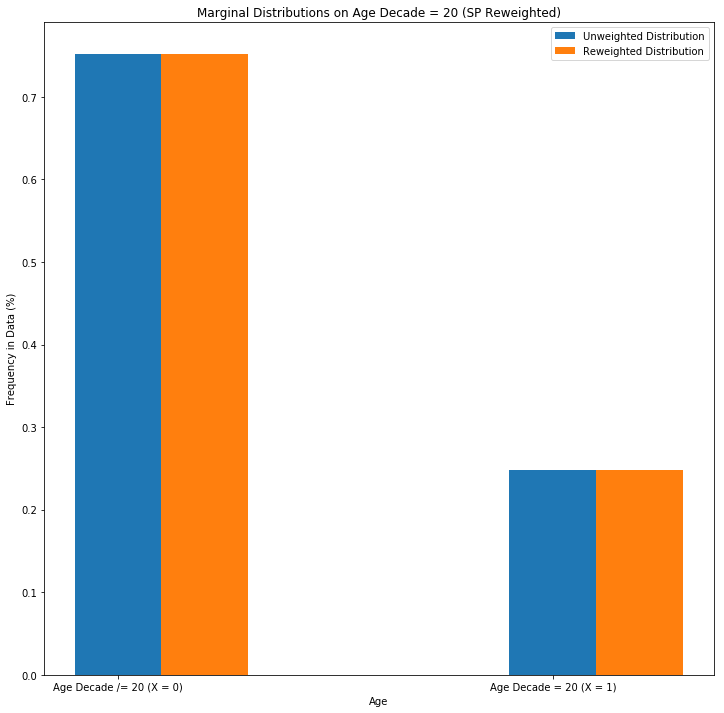

In [86]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 20 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade /= 20 (X = 0)', 'Age Decade = 20 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [87]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=30')
X_age_marginal = marginalize(pred_df, 'Age (decade)=30', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [88]:
table_results['age_30'] = l1_dist(X_age_freq, X_age_marginal)

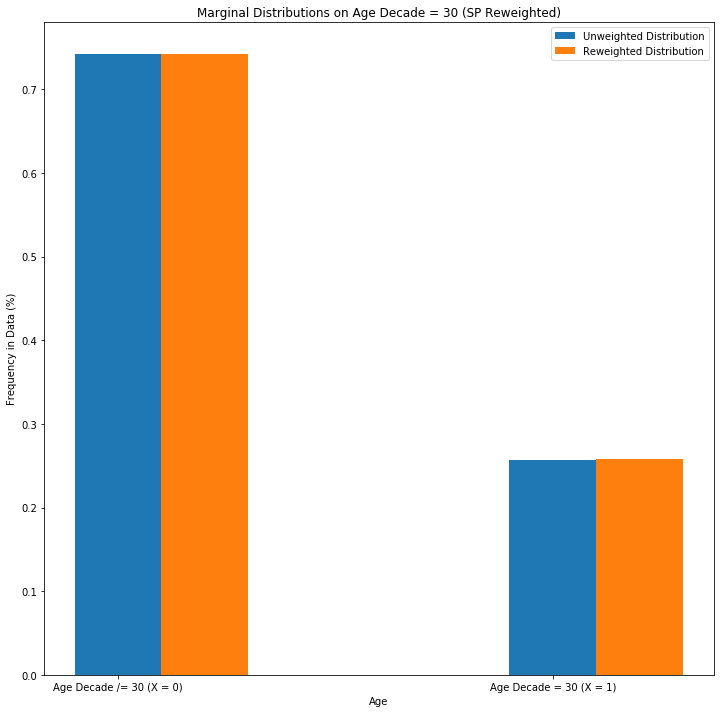

In [89]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 30 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade /= 30 (X = 0)', 'Age Decade = 30 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [90]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=40')
X_age_marginal = marginalize(pred_df, 'Age (decade)=40', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [91]:
table_results['age_40'] = l1_dist(X_age_freq, X_age_marginal)

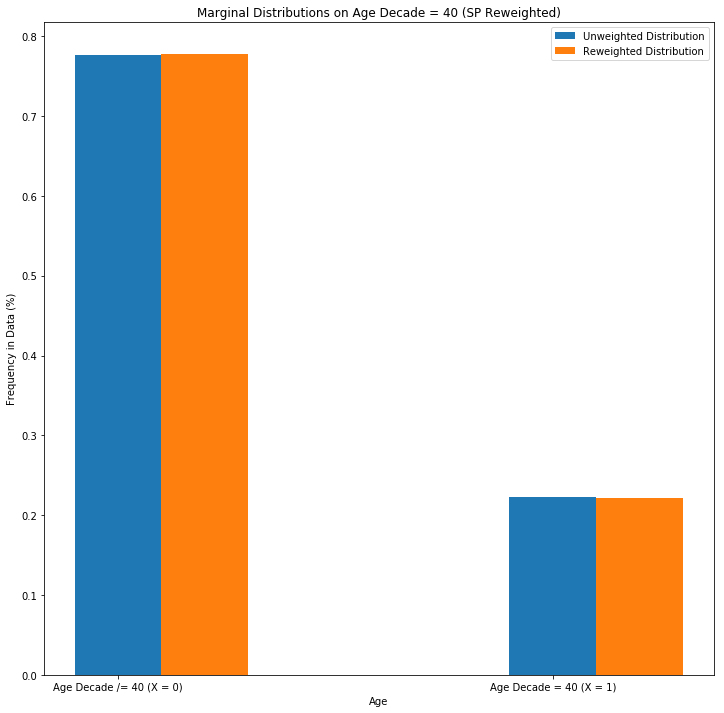

In [92]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 40 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade /= 40 (X = 0)', 'Age Decade = 40 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [93]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=50')
X_age_marginal = marginalize(pred_df, 'Age (decade)=50', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [94]:
table_results['age_50'] = l1_dist(X_age_freq, X_age_marginal)

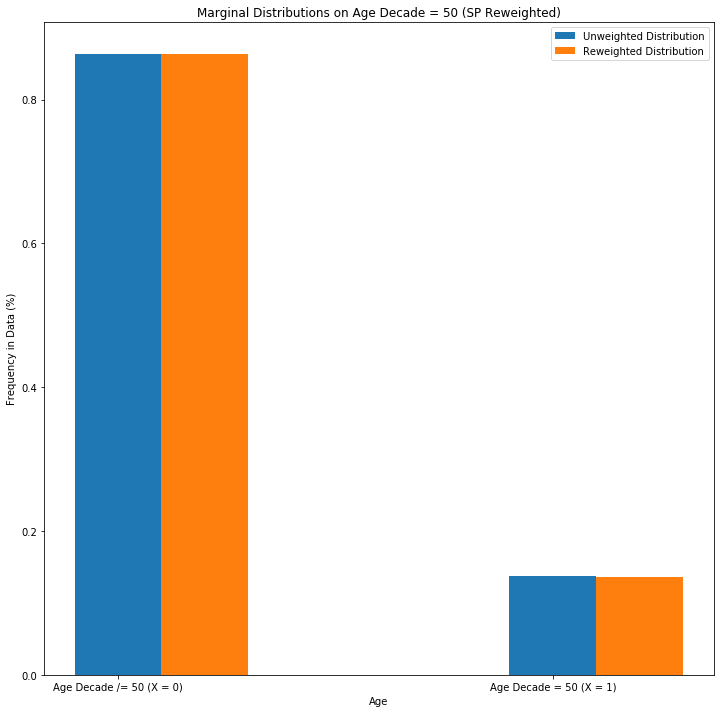

In [95]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 50 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade /= 50 (X = 0)', 'Age Decade = 50 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [96]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=60')
X_age_marginal = marginalize(pred_df, 'Age (decade)=60', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [97]:
table_results['age_60'] = l1_dist(X_age_freq, X_age_marginal)

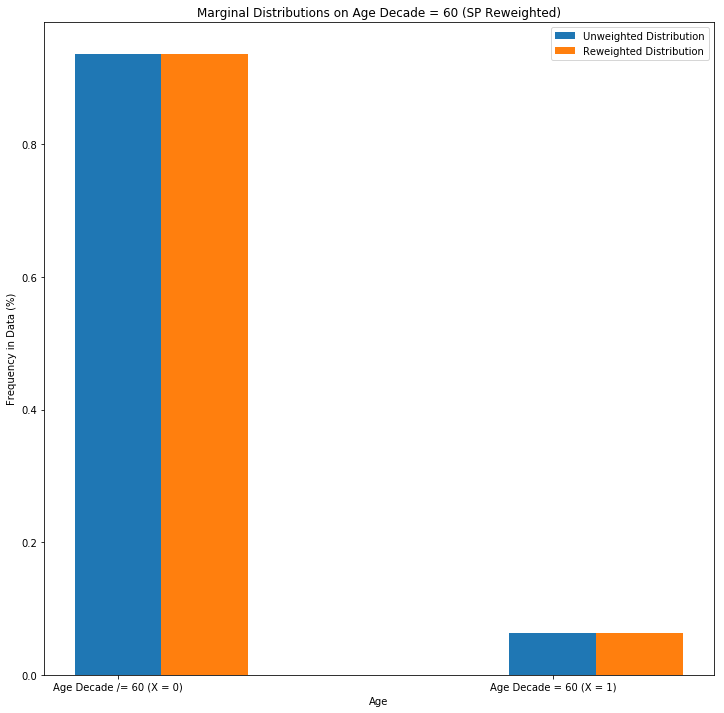

In [98]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 60 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade /= 60 (X = 0)', 'Age Decade = 60 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [99]:
X_age_freq = freq_dict(pred_df, 'Age (decade)=>=70')
X_age_marginal = marginalize(pred_df, 'Age (decade)=>=70', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [100]:
table_results['age_70'] = l1_dist(X_age_freq, X_age_marginal)

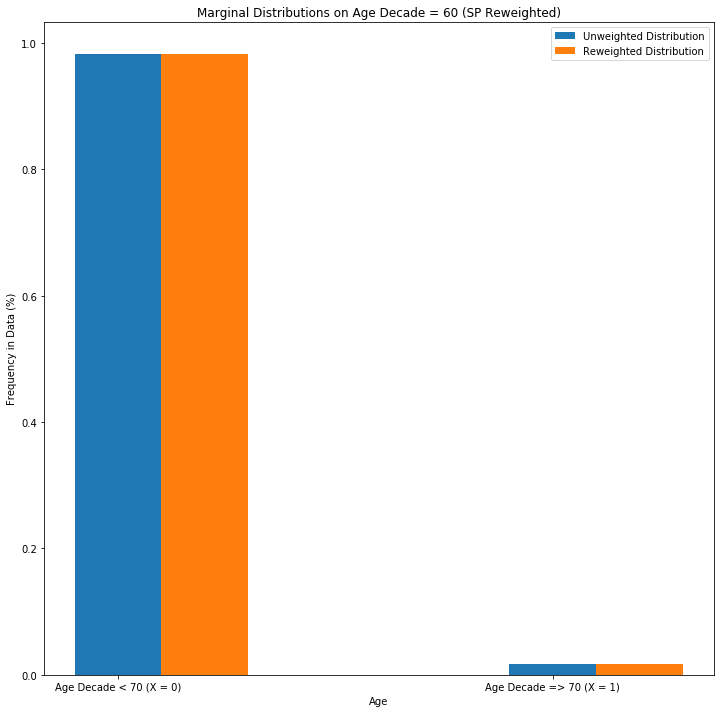

In [101]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age Decade = 60 (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Age Decade < 70 (X = 0)', 'Age Decade => 70 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [102]:
# Got tired of doing this manually
X_education_dict = {}
edu_string = 'Education Years=' 

for i in range(6,13):
    feature = edu_string + str(i)
    X_edu_freq = freq_dict(pred_df, feature)
    X_edu_marginal = marginalize(pred_df, feature, pred_df['weights'])
    X_edu_tuple = graph_tuple(X_edu_freq, X_edu_marginal)
    X_education_dict[feature] = [X_edu_marginal.keys(), X_edu_tuple]
    
    table_label = 'edu' + str(i)
    # print(table_label)
    table_results[table_label] = l1_dist(X_edu_freq, X_edu_marginal)

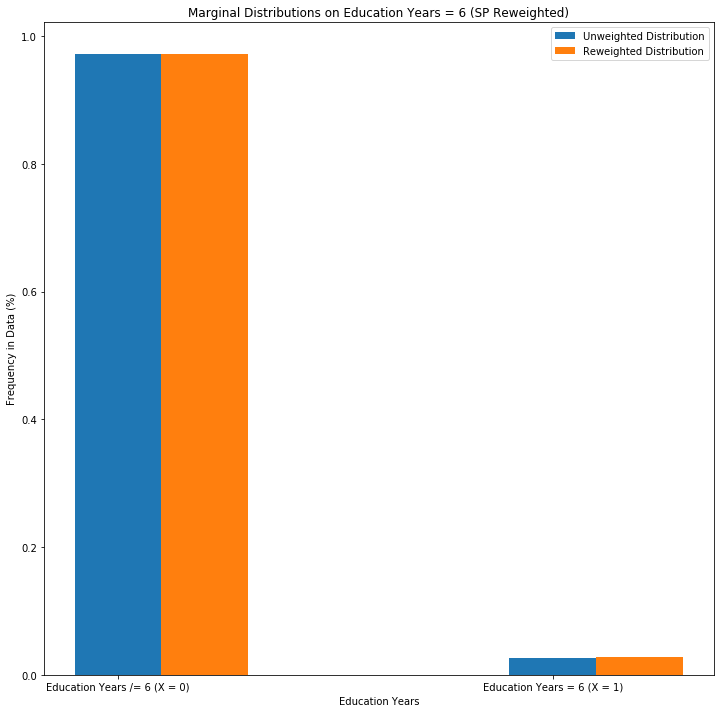

In [103]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=6'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 6 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=6'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=6'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 6 (X = 0)', 'Education Years = 6 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

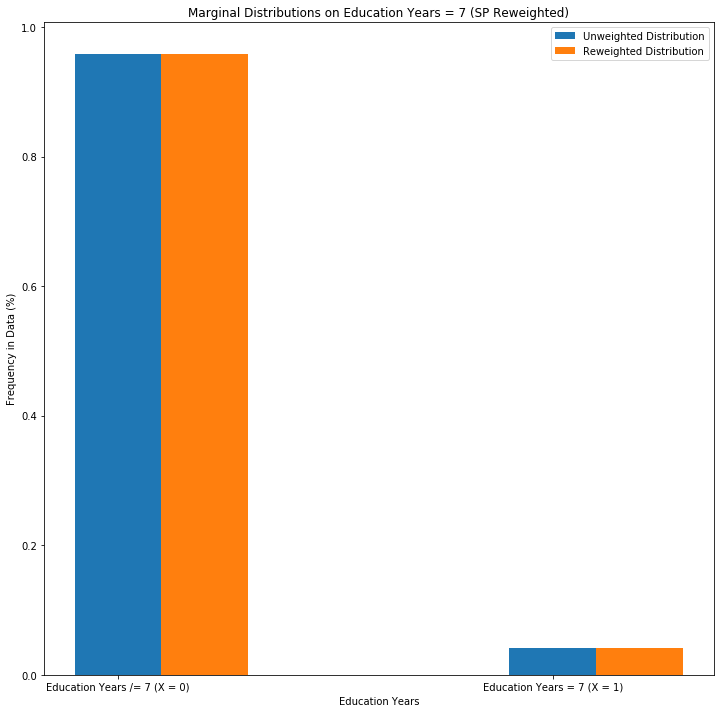

In [104]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=7'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 7 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=7'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=7'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 7 (X = 0)', 'Education Years = 7 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

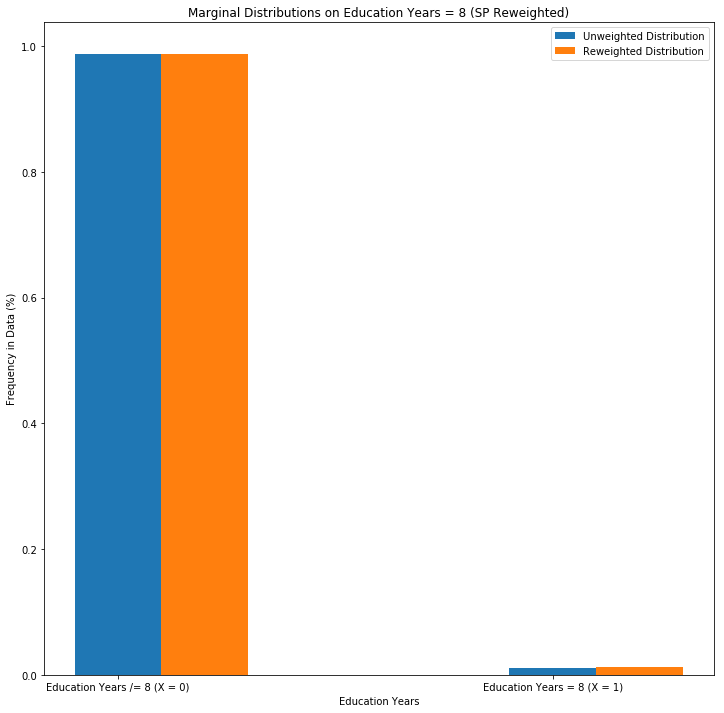

In [105]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=8'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 8 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=8'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=8'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 8 (X = 0)', 'Education Years = 8 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

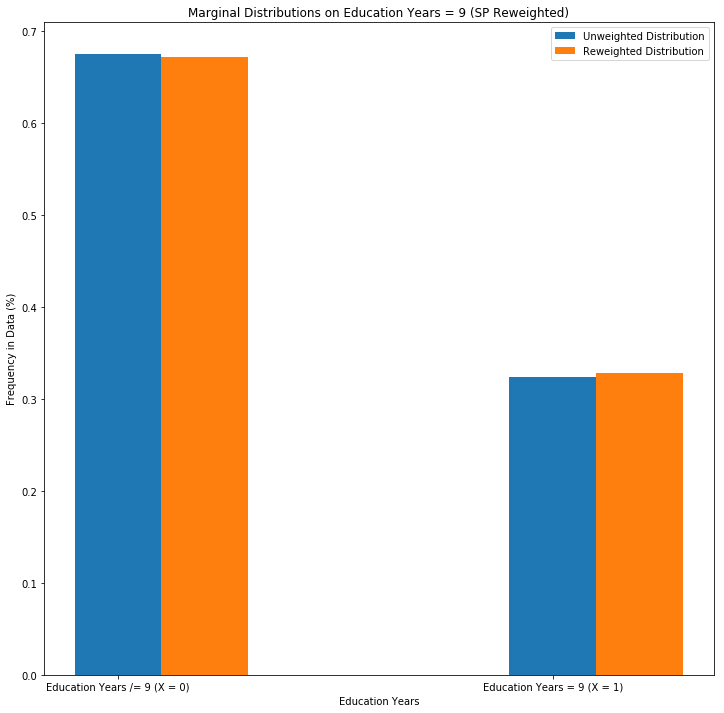

In [106]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=9'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 9 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=9'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=9'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 9 (X = 0)', 'Education Years = 9 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

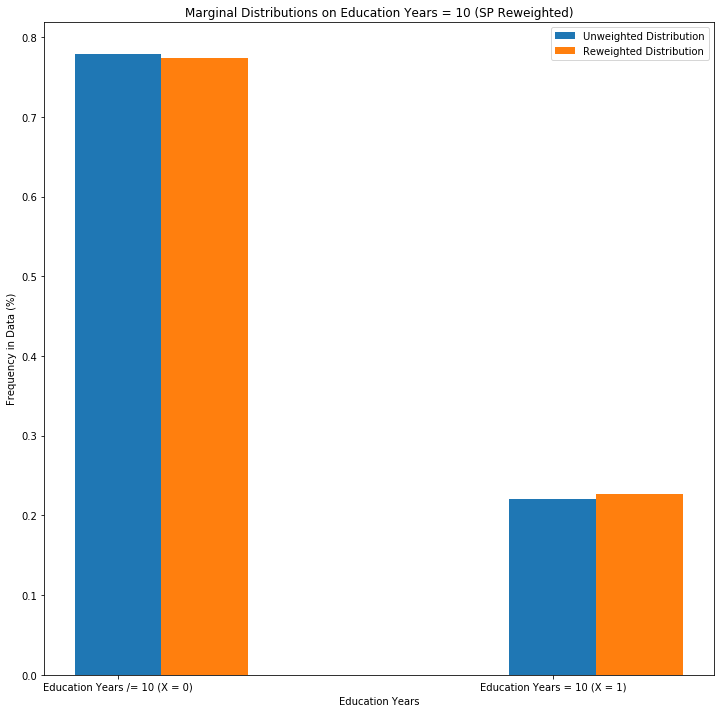

In [107]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=10'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 10 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=10'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=10'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 10 (X = 0)', 'Education Years = 10 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

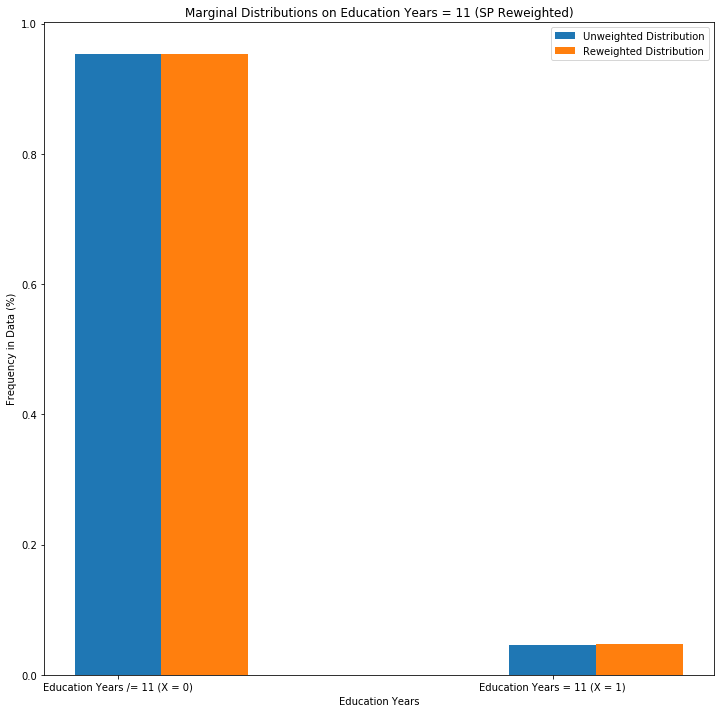

In [108]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=11'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 11 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=11'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=11'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 11 (X = 0)', 'Education Years = 11 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

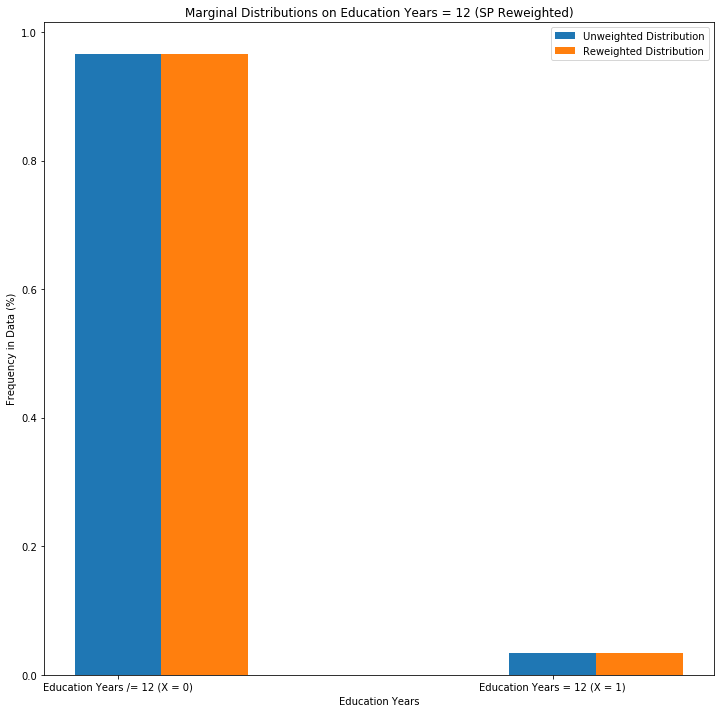

In [109]:
# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=12'][0]))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years = 12 (SP Reweighted)')
plt.bar(X, X_education_dict['Education Years=12'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=12'][1][1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years /= 12 (X = 0)', 'Education Years = 12 (X = 1)'])
plt.xlabel('Education Years')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [110]:
X_edu_freq = freq_dict(pred_df, 'Education Years=<6')
X_edu_marginal = marginalize(pred_df, 'Education Years=<6', pred_df['weights'])
X_edu_tuple = graph_tuple(X_edu_freq, X_edu_marginal)

In [111]:
table_results['edu_>6'] = l1_dist(X_edu_freq, X_edu_marginal)

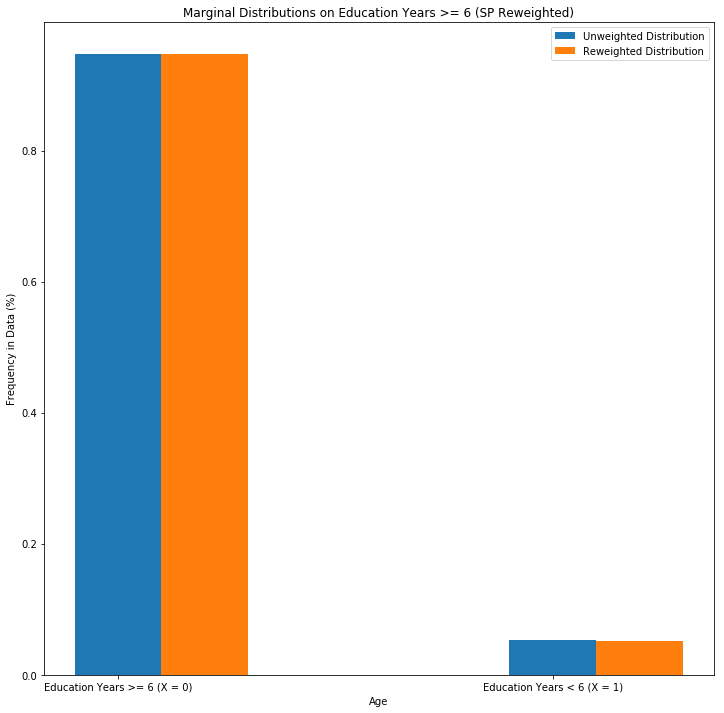

In [112]:
# Marginal Distribution on Age 
X = np.asarray(list(X_edu_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years >= 6 (SP Reweighted)')
plt.bar(X, X_edu_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_edu_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years >= 6 (X = 0)', 'Education Years < 6 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [113]:
X_edu_freq = freq_dict(pred_df, 'Education Years=>12')
X_edu_marginal = marginalize(pred_df, 'Education Years=>12', pred_df['weights'])
X_edu_tuple = graph_tuple(X_edu_freq, X_edu_marginal)

In [114]:
table_results['edu_>12'] = l1_dist(X_edu_freq, X_edu_marginal)

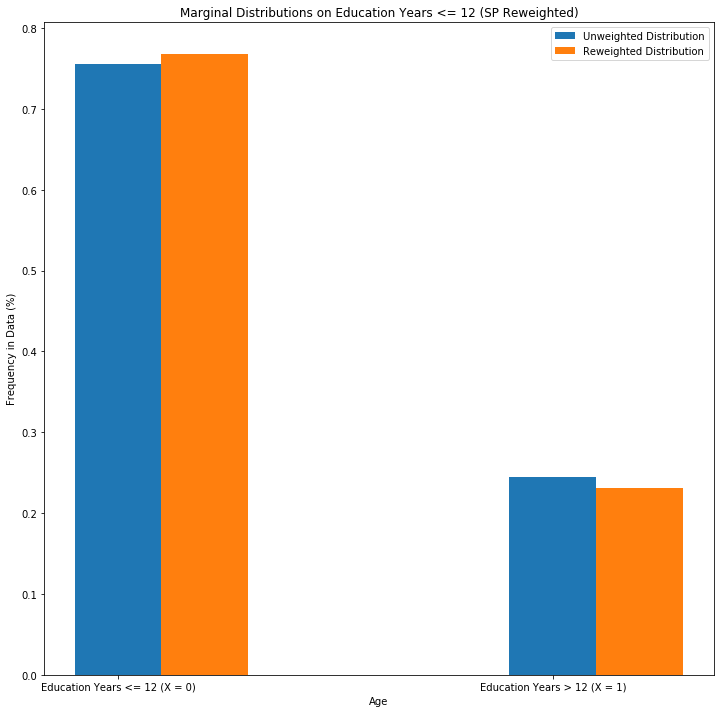

In [115]:
# Marginal Distribution on Age 
X = np.asarray(list(X_edu_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Education Years <= 12 (SP Reweighted)')
plt.bar(X, X_edu_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_edu_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Education Years <= 12 (X = 0)', 'Education Years > 12 (X = 1)'])
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

## Table Results

In [116]:
table_results.keys()

dict_keys(['epsilon', 'initial_unfairness', 'acc', 'sex', 'race', 'age_10', 'age_20', 'age_30', 'age_40', 'age_50', 'age_60', 'age_70', 'edu6', 'edu7', 'edu8', 'edu9', 'edu10', 'edu11', 'edu12', 'edu_>6', 'edu_>12'])

In [117]:
table_results['initial_unfairness']

[0.003987901809669445, -0.03810155086808888]

In [118]:
table_df = pd.DataFrame(table_results, index =['Adult_EO_Y0', 'Adult_EO_Y1'])

In [119]:
table_df

,epsilon,initial_unfairness,acc,sex,race,age_10,age_20,age_30,age_40,age_50,...,age_70,edu6,edu7,edu8,edu9,edu10,edu11,edu12,edu_>6,edu_>12
Adult_EO_Y0,0.47,0.003988,0.788863,0.001540,0.002088,0.000835,0.002135,0.001114,0.002645,0.001995,...,0.000139,0.000789,0.001903,0.00051,0.008585,0.012019,0.001439,0.001346,0.001021,0.025568
Adult_EO_Y1,0.17,-0.038102,0.788863,0.000789,0.002088,0.000835,0.002135,0.001114,0.002645,0.001995,...,0.000139,0.000789,0.001903,0.00051,0.008585,0.012019,0.001439,0.001346,0.001021,0.025568


In [120]:
table_df.to_csv('./result_tables/Adult_EO.csv')